In [1]:
# Autoencoder SelfieDS
# Miguelangel Moreno Sotelo

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import random
import time
import pickle
import keras
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.models import model_from_json
from keras import optimizers
from keras import losses
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from PIL import Image,ImageOps

Using TensorFlow backend.


## DataSet

In [2]:
class DataSet:
    data_train = None;
    data_valid = None;
    
    # Pickle de train cargado al momento
    current_pickle_tra = 1;    
    
    # imagenes   46,836
    # train      42,836
    # validation  2,000
    # test        2,000
    
    total_train  = 44836; 
    total_valid  = 2000; 
       
    def read_pickle(self, name, show=False):
        
        if show:
            print('Cargando pickle',"../DataSet/{}.pickle".format(name));
        pic = pickle.load(open("../DataSet/{}.pickle".format(name), "rb"));
        
        X = np.array(pic['X']);   
        Y = np.array(pic['Y']);
        
        if show:
           print('X-',X.shape)
           print('Y-',Y.shape)        
                
        return X,Y;
                         
        
    def load_dataset(self):
        self.data_train = dict(X=[],Y=[]);
        self.data_valid = dict(X=[],Y=[]);
        
        for i in range(1,6):
            x,y = self.read_pickle('train_selfieds_{}'.format(i), show=True);
            self.data_train['X'].extend(x);
            self.data_train['Y'].extend(y);
        
        x,y = self.read_pickle('validation_selfieds_1', show=True);
        self.data_valid['X'].extend(x);
        self.data_valid['Y'].extend(y);
        
        x,y = self.read_pickle('test_selfieds_1', show=True);
        self.data_train['X'].extend(x);
        self.data_train['Y'].extend(y);
        
        new = [];
        for i,x in enumerate(self.data_train['X']):
            #plt.imshow(x);
            #plt.show();
            
            
            image = Image.fromarray(x)           

            

            # Fit a la imagen
            img_dim = (208,208);
            image = ImageOps.fit(image,(img_dim[0],img_dim[1]),Image.ANTIALIAS,centering=(0.5, 0.5));
#             image = image.convert('P')
            image = image.convert('L')
            image = np.array(image).reshape(img_dim[1],img_dim[0],1)
            
            new.append(image);
            
#             plt.imshow(image,cmap='gray');
#             plt.show();
#             print(image)
#             break;
            
                
        self.data_train['X'] = np.array(new);
        
        new = [];
        for i,x in enumerate(self.data_valid['X']):
            image = Image.fromarray(x)     

            # Fit a la imagen
            img_dim = (208,208);
            image = ImageOps.fit(image,(img_dim[0],img_dim[1]),Image.ANTIALIAS,centering=(0.5, 0.5));
            image = image.convert('P')
            image = np.array(image).reshape(img_dim[1],img_dim[0],1)
            
            new.append(image);
            
            #plt.imshow(image);
            #plt.show();
            
                
        self.data_valid['X'] = np.array(new);
        
        print('\nTotal Train Data X:',self.data_train['X'].shape,'Y:',len(self.data_train['Y']));
        print('\nTotal Valid Data X:',self.data_valid['X'].shape,'Y:',len(self.data_valid['Y']));
        
    
    def get_batch(self, batch_number, batch_size, show=False):
                          
        # Seleccion de slice de acuerdo al batch 
        slice_end   = batch_size * batch_number;
        slice_start = slice_end - batch_size;
                                      
        if show:
            print('\nBatch_number ',batch_number)
            print('Slice real',slice_start,slice_end)
                             
        X_batch = self.data_train['X'][slice_start:slice_end];
        Y_batch = self.data_train['Y'][slice_start:slice_end]; 
               
      
        if show:
            print('X_batch', len(X_batch));
            print('Y_batch', len(Y_batch));

        return {'X_batch':X_batch,'Y_batch':Y_batch}
    

    

In [3]:
# Cargamos Dataset
ds = DataSet();
ds.load_dataset();

Cargando pickle ../DataSet/train_selfieds_1.pickle
X- (9200, 200, 200, 3)
Y- (9200, 36)
Cargando pickle ../DataSet/train_selfieds_2.pickle
X- (9200, 200, 200, 3)
Y- (9200, 36)
Cargando pickle ../DataSet/train_selfieds_3.pickle
X- (9200, 200, 200, 3)
Y- (9200, 36)
Cargando pickle ../DataSet/train_selfieds_4.pickle
X- (9200, 200, 200, 3)
Y- (9200, 36)
Cargando pickle ../DataSet/train_selfieds_5.pickle
X- (6036, 200, 200, 3)
Y- (6036, 36)
Cargando pickle ../DataSet/validation_selfieds_1.pickle
X- (2000, 200, 200, 3)
Y- (2000, 36)
Cargando pickle ../DataSet/test_selfieds_1.pickle
X- (2000, 200, 200, 3)
Y- (2000, 36)

Total Train Data X: (44836, 208, 208, 1) Y: 44836

Total Valid Data X: (2000, 208, 208, 1) Y: 2000


# Arquitectura

In [62]:
# Definicion de la Arquitectura

input_img = Input(shape=(208, 208, 1))

filter_size = (3,3);

fmap = 4;

bn_model = 0

x = Conv2D(fmap, filter_size, activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
print(x)

x = Conv2D(fmap*2,filter_size, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
print(x)

x = Conv2D(fmap*4, filter_size, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
print(x)

#x = Conv2D(fmap*8, filter_size, activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#print(x)

#x = Conv2D(fmap*16, filter_size, activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#print(x)

print('encode')
encoded = x;


x = Conv2D(fmap*2, filter_size, activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
print(x)

x = Conv2D(fmap*1, filter_size, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
print(x)

#x = Conv2D(fmap*2, filter_size, activation='relu', padding='valid')(x)
#x = UpSampling2D((2, 2))(x)
#print(x)

#x = Conv2D(fmap*1, filter_size, activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
#print(x)

x = Conv2D(1, filter_size, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
print(x)


decoded = x


adam = optimizers.adam(lr=1e-3)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=adam, loss=losses.mean_squared_error)



Tensor("max_pooling2d_19/MaxPool:0", shape=(?, 104, 104, 4), dtype=float32)
Tensor("max_pooling2d_20/MaxPool:0", shape=(?, 52, 52, 8), dtype=float32)
Tensor("max_pooling2d_21/MaxPool:0", shape=(?, 26, 26, 16), dtype=float32)
encode
Tensor("up_sampling2d_19/ResizeNearestNeighbor:0", shape=(?, 52, 52, 8), dtype=float32)
Tensor("up_sampling2d_20/ResizeNearestNeighbor:0", shape=(?, 104, 104, 4), dtype=float32)
Tensor("up_sampling2d_21/ResizeNearestNeighbor:0", shape=(?, 208, 208, 1), dtype=float32)


In [5]:
autoencoder.summary();

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 208, 208, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 208, 208, 4)       40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 104, 104, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 104, 104, 8)       296       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 52, 52, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 16)        1168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 16)        0         
__________

# Entrenamiento

In [19]:
def save_model(index=0):
    model_json = autoencoder.to_json()
    with open("acoder_train_{}.json".format(index), "w") as json_file:
        json_file.write(model_json)
    autoencoder.save_weights("acoder_train_{}.h5".format(index),)
    print("Modelo guardado en disco","acoder_train_{}.h5".format(index))

In [54]:
save = 1;

In [16]:
global_history = {'val_loss':[], 'loss':[]}
min_val_loss = 1000;

In [64]:
for i in range(0,200):
    h = autoencoder.fit(ds.data_train['X'], ds.data_train['X'],
                epochs=1,
                batch_size=100,
                shuffle=False,
                validation_data=(ds.data_valid['X'], ds.data_valid['X']))

    global_history['val_loss'].extend(h.history['val_loss'])
    global_history['loss'].extend(h.history['loss'])
    
    val_loss = h.history['val_loss'][0];
       
    if val_loss < min_val_loss:
        min_val_loss = val_loss;
        save_model(index=save);

Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 19s 417us/step - loss: 241.1227 - val_loss: 347.5339
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 18s 409us/step - loss: 228.2843 - val_loss: 347.4156
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 18s 411us/step - loss: 228.6299 - val_loss: 349.9189
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 18s 411us/step - loss: 229.8015 - val_loss: 347.6883
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 18s 410us/step - loss: 229.7353 - val_loss: 347.1016
Modelo guardado en disco acoder_train_1.h5
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 18s 411us/step - loss: 229.5475 - val_loss: 346.7743
Mod

44836/44836 [==============================] - 18s 412us/step - loss: 227.2970 - val_loss: 350.4675
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 19s 414us/step - loss: 227.6815 - val_loss: 345.5827
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 18s 412us/step - loss: 227.6179 - val_loss: 346.2063
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 19s 413us/step - loss: 227.1701 - val_loss: 349.8419
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 18s 412us/step - loss: 227.6214 - val_loss: 345.2289
Modelo guardado en disco acoder_train_1.h5
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 19s 413us/step - loss: 227.3032 - val_loss: 345.2264
Modelo guardado en disco acoder_train_1.h5
Train on 44836 samp

44836/44836 [==============================] - 19s 427us/step - loss: 225.9086 - val_loss: 344.9535
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 19s 413us/step - loss: 225.7470 - val_loss: 343.9723
Modelo guardado en disco acoder_train_1.h5
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 18s 411us/step - loss: 225.6028 - val_loss: 344.4388
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 19s 413us/step - loss: 226.0316 - val_loss: 344.2300
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 18s 413us/step - loss: 225.7270 - val_loss: 345.6219
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 18s 413us/step - loss: 225.4597 - val_loss: 343.8691
Modelo guardado en disco acoder_train_1.h5
Train on 44836 samp

Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 18s 411us/step - loss: 224.5456 - val_loss: 343.5575
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 18s 412us/step - loss: 224.2249 - val_loss: 348.2873
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 19s 414us/step - loss: 224.3749 - val_loss: 343.4521
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 18s 412us/step - loss: 224.2367 - val_loss: 346.4401
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 19s 423us/step - loss: 224.4656 - val_loss: 344.8075
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 19s 418us/step - loss: 224.2965 - val_loss: 344.5727
Train on 44836 samples, validate on 2000 sampl

Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 18s 412us/step - loss: 222.9839 - val_loss: 345.6040
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 19s 426us/step - loss: 222.9502 - val_loss: 342.4156
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 19s 426us/step - loss: 222.9354 - val_loss: 343.3624
Train on 44836 samples, validate on 2000 samples
Epoch 1/1
44836/44836 [==============================] - 19s 415us/step - loss: 223.1031 - val_loss: 343.1630


In [66]:
autoencoder.load_weights("acoder_train_1.h5")

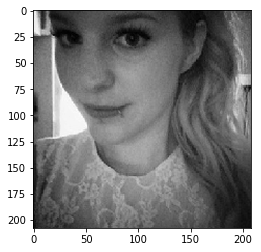

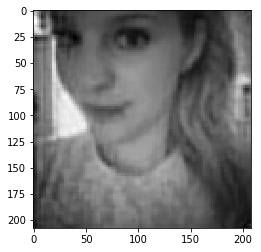

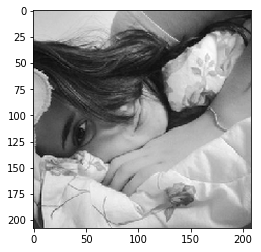

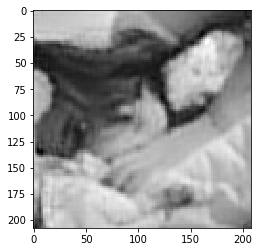

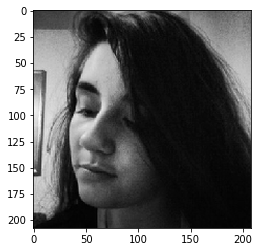

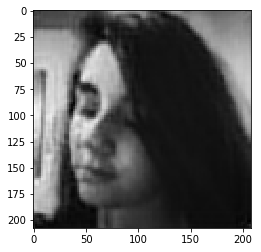

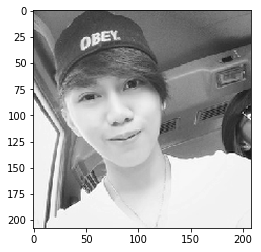

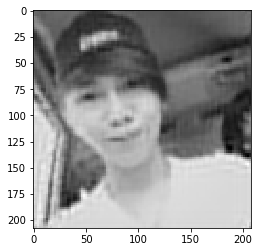

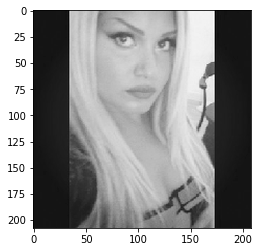

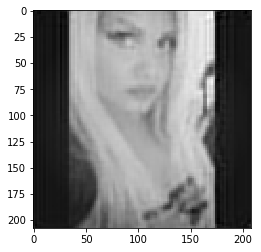

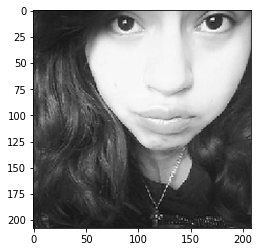

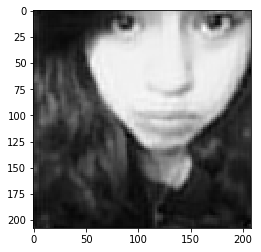

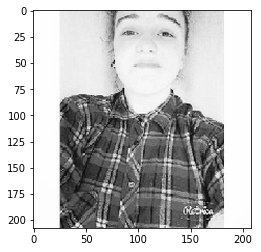

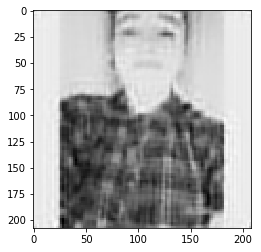

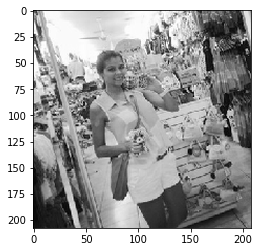

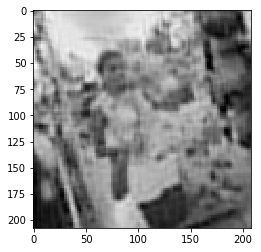

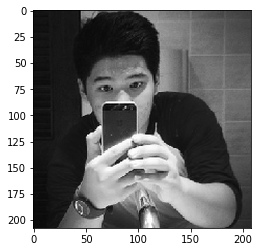

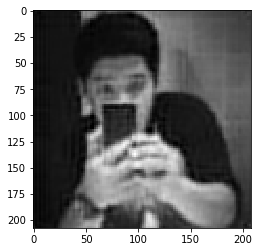

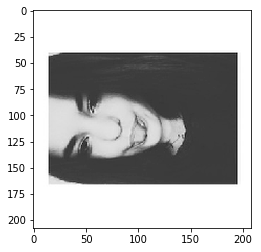

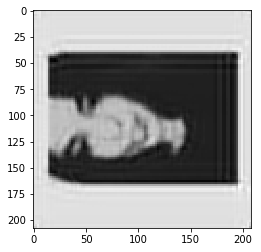

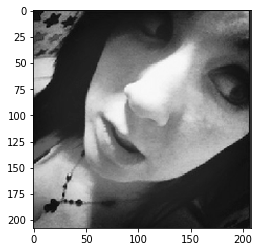

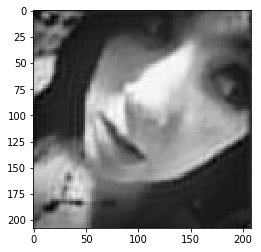

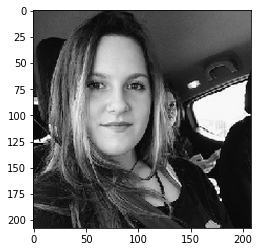

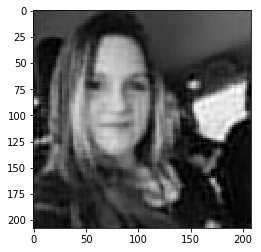

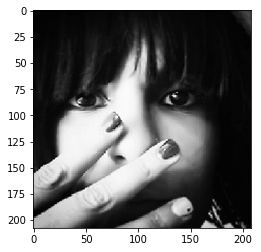

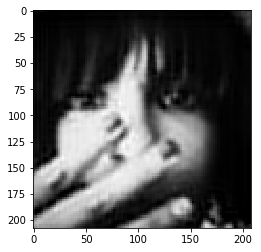

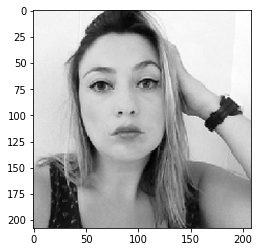

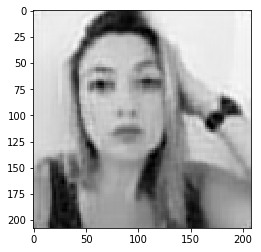

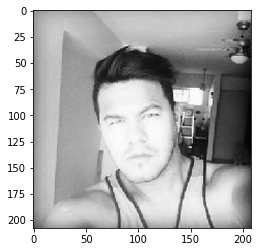

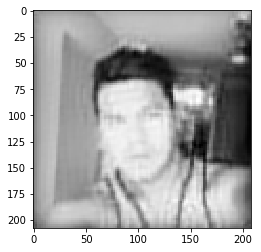

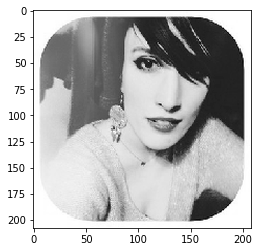

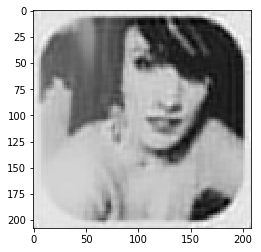

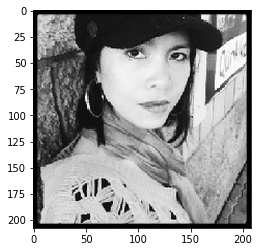

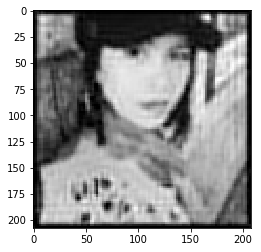

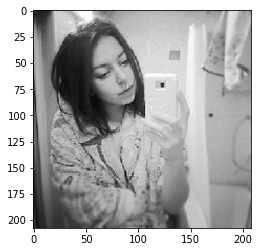

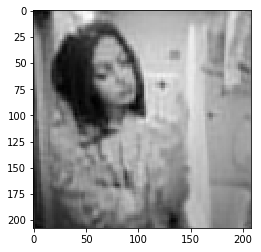

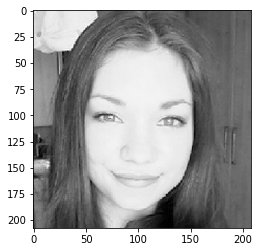

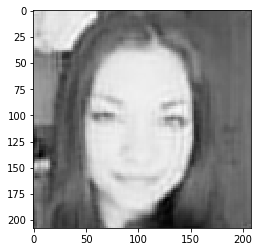

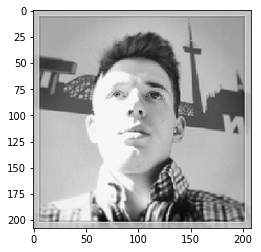

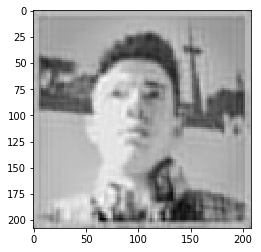

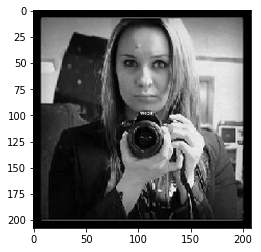

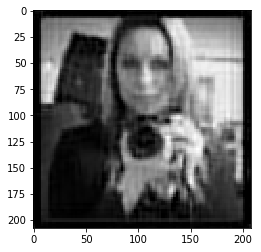

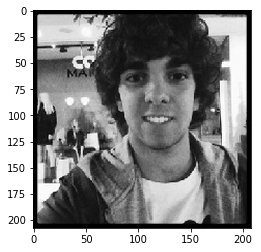

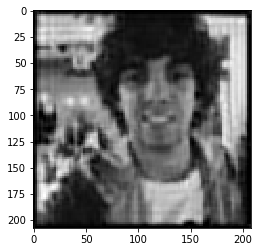

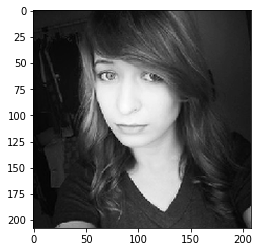

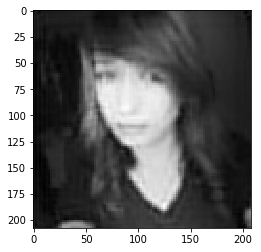

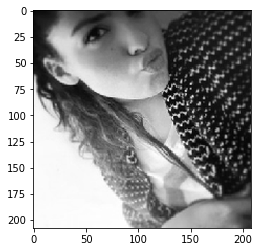

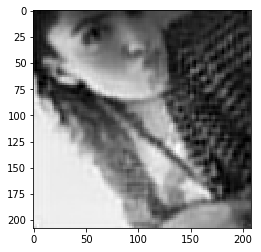

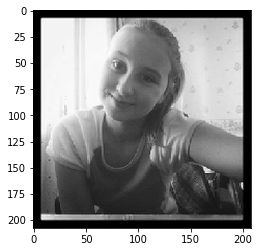

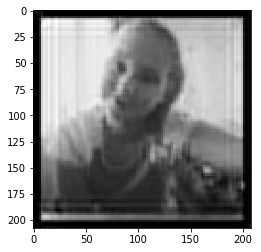

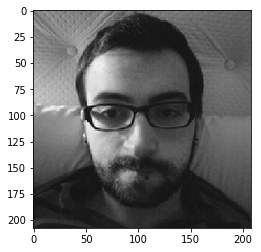

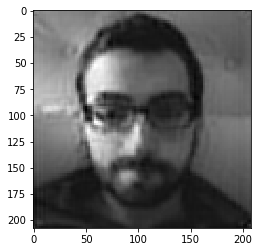

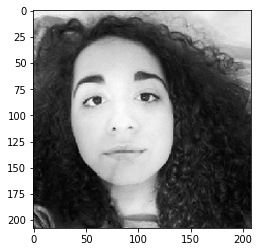

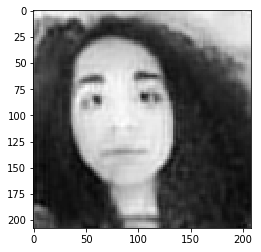

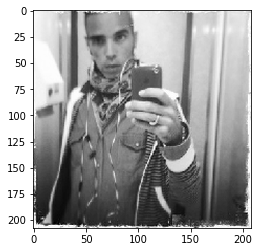

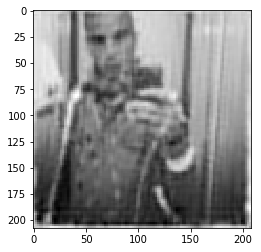

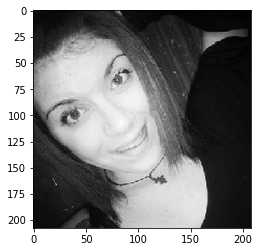

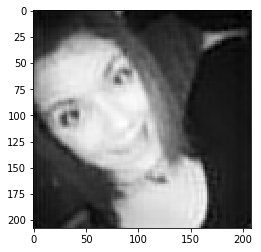

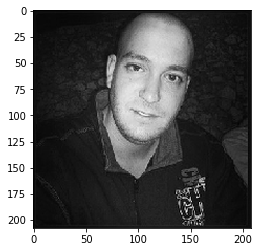

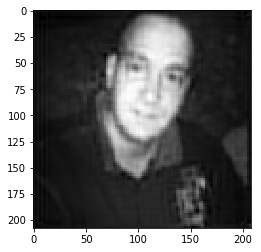

(208, 208, 1)


In [67]:
# Plot
x_test = ds.data_train['X'][0:30];
x_recon = autoencoder.predict(x_test)

for i in range(len(x_test)):
    plt.imshow(x_test[i].reshape(208,208), cmap='gray');
    plt.show();
    
    plt.imshow(x_recon[i].reshape(208,208), cmap='gray');
    plt.show();

print(x_recon[0].shape)
# plt.savefig('reconstructions.png')

In [68]:
print(min(global_history['val_loss']))

342.2736312866211


In [69]:
print(global_history['val_loss'])

[687.1827545166016, 607.3909118652343, 452.9446334838867, 437.3665054321289, 428.0535385131836, 420.33238372802737, 415.93836669921876, 410.17545928955076, 403.1642440795898, 405.77724609375, 397.5116241455078, 395.3420867919922, 393.0203155517578, 391.00787353515625, 389.0692138671875, 387.86473083496094, 386.8374755859375, 384.60375518798827, 383.27268676757814, 382.40308074951173, 380.9112182617188, 381.52671966552737, 378.637760925293, 376.9374374389648, 375.9796447753906, 374.9320297241211, 379.28063201904297, 376.8208770751953, 373.98419189453125, 372.1995483398438, 371.20569763183596, 370.4007171630859, 370.50281982421876, 369.6592086791992, 369.3478179931641, 369.69322509765624, 368.7907318115234, 367.62074584960936, 367.0833511352539, 367.1864212036133, 366.5401977539062, 366.70434417724607, 369.8899520874023, 368.80955810546874, 369.47239074707034, 364.7335678100586, 368.72113037109375, 364.5195373535156, 363.8154830932617, 364.5863296508789, 366.6375015258789, 365.1739974975

In [70]:
print(global_history['loss'])

[3400.559939632642, 642.5895500254574, 454.6207938669453, 373.4855407856419, 354.5484600354713, 342.26301765424876, 333.1904024724308, 325.27989613198395, 313.8175592666668, 309.3438901143172, 305.7026196004279, 301.18632996166326, 297.6947701602459, 294.64511697159816, 291.57267250471466, 288.77584147191686, 286.58172527241425, 284.8188298218852, 282.632124245438, 281.0072596346899, 279.1754332695651, 277.7759650736896, 276.1498605764054, 274.1407289296556, 271.9978073369235, 270.66147335888667, 269.05952712532155, 268.079090625832, 267.05094783067256, 265.90660889259954, 264.98983786293076, 264.1138410620137, 263.2340763938428, 262.50712603009964, 261.67641247842835, 260.9804281560942, 260.4246880378761, 259.7171972912719, 259.22678212500966, 258.73851490182403, 258.1908800851885, 257.4346932581271, 257.2312482741464, 256.88341310875285, 256.1565783437116, 255.99741032525787, 255.31734276719732, 255.25278214594098, 254.42311195157768, 254.47772047995926, 253.90987016778422, 253.54182

In [71]:
%matplotlib inline

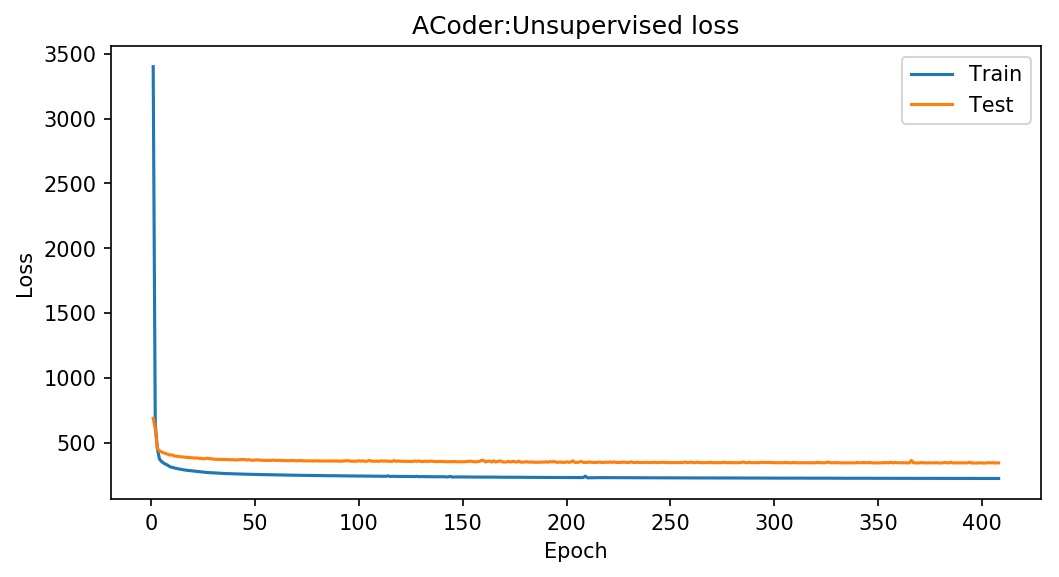

In [72]:
# Plot training & validation loss values
fig =plt.figure(figsize=(8,4),dpi=150)
fig,axes=plt.subplots(figsize=(8,4),dpi=150)
x = np.arange(1,409,1);

axes.plot(x, global_history['loss'][0:500])
axes.plot(x, global_history['val_loss'][0:500])

plt.title('ACoder:Unsupervised loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')


fig.savefig("acoder_unsup-full.png",dpi=150) 

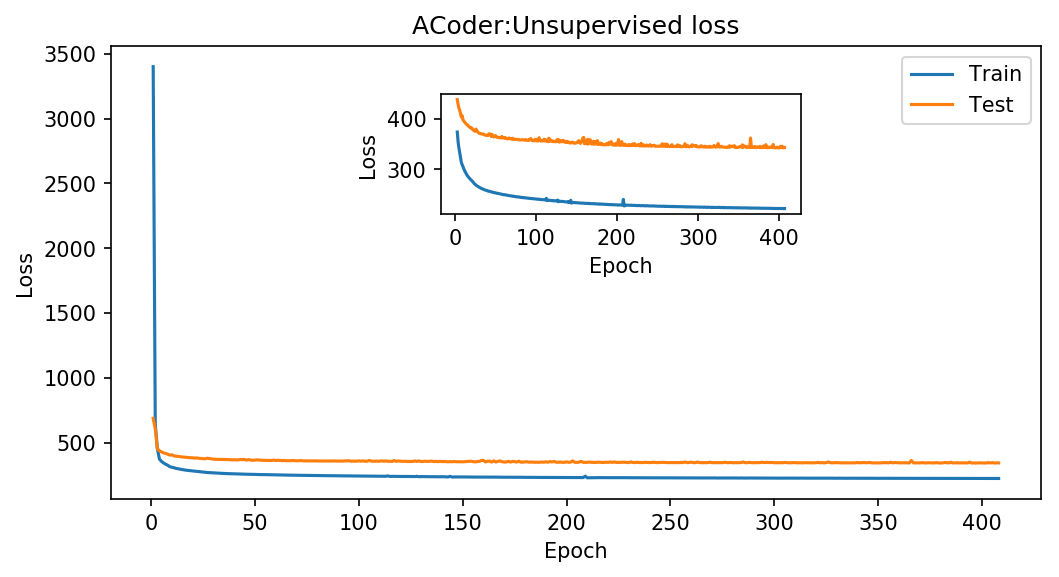

In [73]:
fig =plt.figure(figsize=(8,4),dpi=150)
fig,axes=plt.subplots(figsize=(8,4),dpi=150)

x = np.arange(1,409,1);
axes.plot(x, global_history['loss'][0:500])
axes.plot(x, global_history['val_loss'][0:500])
plt.title('ACoder:Unsupervised loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

zoom_init = 3;
x = np.arange(zoom_init,408,1);
axes2=fig.add_axes([0.4,0.6,0.3,0.2])
axes2.plot(x, global_history['loss'][zoom_init:500])
axes2.plot(x, global_history['val_loss'][zoom_init:500])
axes2.set_xlabel("Epoch")
axes2.set_ylabel("Loss")

fig.savefig("acoder_unsup-mix.png",dpi=150) 